In [7]:
import os 
import glob
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.io import loadmat


# DaLiA Dataset

In [40]:
data_path = "C:/Users/cleme/ETH/Master/Thesis/data/DaLiA/data/PPG_FieldStudy"
participant_paths = glob.glob(os.path.join(data_path, '**', '*_quest.csv'), recursive=True)
series = []
for participant in participant_paths:
   row = pd.read_csv(participant, header=None).T
   row.columns = [el.split(" ")[1] for el in row.iloc[0]]
   row = row.drop(row.index[0])
   series.append(row) 

df = pd.concat(series, ignore_index=True)
df

,SUBJECT_ID,AGE,GENDER,HEIGHT,WEIGHT,SKIN,SPORT
0,S1,34,m,182,78,3,6
1,S10,55,f,164,56,4,5
2,S11,24,f,168,62,3,5
3,S12,43,m,195,105,3,5
4,S13,21,f,170,63,3,6
5,S14,26,f,170,67,3,4
6,S15,28,m,183,79,2,5
7,S2,28,m,189,80,3,5
8,S3,25,m,170,60,3,5
9,S4,25,m,168,57,4,5


<Axes: >

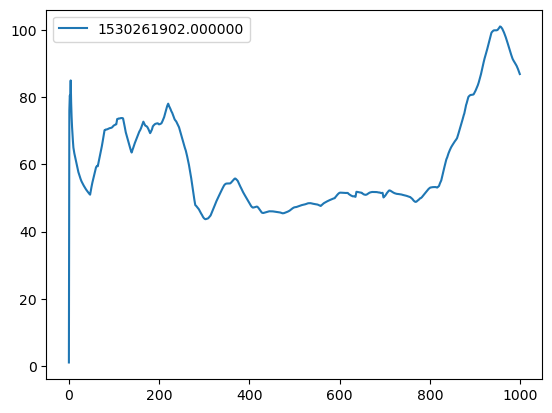

In [49]:
bvp = pd.read_csv(data_path + "/S1/S1_E4/HR.csv")
bvp[:1000].plot()

In [ ]:
import pickle

with open(data_path + "/S1/S1.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")
data

{'rpeaks': array([    240,    1174,    2128, ..., 6447292, 6447748, 6448224]),
 'signal': {'chest': {'ACC': array([[ 0.85640001, -0.06779999, -0.36559999],
          [ 0.8556    , -0.06900001, -0.3646    ],
          [ 0.852     , -0.07020003, -0.3642    ],
          ...,
          [ 0.88759995, -0.1038    , -0.27920002],
          [ 0.88619995, -0.10159999, -0.27819997],
          [ 0.88680005, -0.10140002, -0.27380002]]),
   'ECG': array([[0.01560974],
          [0.01812744],
          [0.01753235],
          ...,
          [0.21368408],
          [0.21556091],
          [0.21702576]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
          [-273.15]], dt

<Axes: >

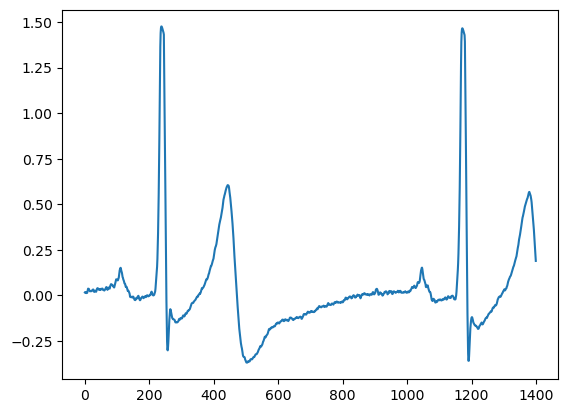

In [63]:
pd.Series(data['signal']['chest']['ECG'][:1400][:,0]).plot()

In [ ]:
data['signal']['wrist']['BVP']

(589568, 1)

# UCIHAR Dataset

In [35]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/UCIHAR/UCI HAR Dataset/UCI HAR Dataset/test/"
x_train = np.loadtxt(datadir  + "X_test.txt")
y_train = np.loadtxt(datadir + "y_test.txt")
subjects = np.loadtxt(datadir + "subject_test.txt")

In [39]:
pd.Series(subjects, dtype=int).unique()

array([ 2,  4,  9, 10, 12, 13, 18, 20, 24])

In [ ]:
body_acc_x = np.loadtxt(datadir + "Inertial Signals/body_acc_x_train.txt")

(7352, 128)

In [14]:
print(x_train.shape)

(7352, 561)


In [19]:
pd.Series(subjects).unique()

array([ 1.,  3.,  5.,  6.,  7.,  8., 11., 14., 15., 16., 17., 19., 21.,
       22., 23., 25., 26., 27., 28., 29., 30.])

# USC Dataset

In [ ]:

datadir = "C:/Users/cleme/ETH/Master/Thesis/data/Capture24/capture24/"

# Capture 24

In [ ]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/Capture24/capture24/"
df = pd.read_csv(datadir + "P001.csv")
df

C:\Users\cleme\AppData\Local\Temp\ipykernel_20260\1724369356.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datadir + "P001.csv")


,time,x,y,z,annotation
0,2016-11-13 02:18:00.000000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
1,2016-11-13 02:18:00.010000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
2,2016-11-13 02:18:00.020000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
3,2016-11-13 02:18:00.030000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
4,2016-11-13 02:18:00.040000,-0.466690,-0.533341,0.658472,7030 sleeping;MET 0.95
...,...,...,...,...,...
10019996,2016-11-14 06:07:59.960000,0.049416,-0.797846,0.565700,7030 sleeping;MET 0.95
10019997,2016-11-14 06:07:59.970000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95
10019998,2016-11-14 06:07:59.980000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95
10019999,2016-11-14 06:07:59.990000,0.049416,-0.782285,0.565700,7030 sleeping;MET 0.95


In [21]:
len(df)

10020001

# WildPPG

In [ ]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/WildPPG/data/"
file_path = datadir + "WildPPG_Part_an0.mat"
#data = loadmat(file_path)

In [5]:
from pathlib import Path 
datadir = Path(datadir)
lengths = []
for path in datadir.glob('*.mat'):
    data = loadmat(path)
    lengths.append(data['wrist']['acc_x'][0][0][0][0][2].shape[1])
    del data

In [ ]:
lengths

[5679104,
 5690368,
 6162432,
 7018496,
 6169600,
 6137856,
 6103040,
 6768640,
 6664192,
 5762048,
 6066176,
 5835776,
 6633472,
 6691840,
 6107136,
 6405120]

In [14]:
names = []
for path in datadir.glob("*.mat"):
    names.append(str(path).split("_")[-1][:3])
names

['an0',
 'e61',
 'fex',
 'k2s',
 'kjd',
 'l38',
 'n31',
 'ngh',
 'p5d',
 'p9p',
 'qm9',
 'ssx',
 'trh',
 'tz8',
 'u7y',
 'w4p']

# IEEE Dataset

In [16]:
datadir = "C:/Users/cleme/ETH/Master/Thesis/data/IEEEPPG/"
file_path = datadir + "IEEE_Big.mat"
data = loadmat(file_path)

In [32]:
data['whole_dataset'][0]

array([array([[-0.15877186, -0.73611433, -1.07146451, ..., -0.63894624,
               -0.30886573,  0.17808868],
              [-0.55416434, -0.31065377,  0.11754339, ..., -0.81839013,
               -0.93625415, -0.84427809],
              [-1.52729914, -0.58884415,  0.88678259, ..., -0.03825972,
               -0.42902249, -1.08390654],
              ...,
              [-0.76582042, -1.04059837, -1.2869529 , ...,  0.35689532,
                0.12570946, -0.08977534],
              [ 1.40025155,  0.83537255,  0.45313321, ...,  0.93511269,
                0.95084864,  0.79267789],
              [-0.16112841, -0.03788694,  0.10030634, ...,  0.74729059,
                0.80550889,  0.87048167]])                             ,
       array([[33],
              [30],
              [29],
              [29],
              [30],
              [29],
              [30],
              [31],
              [33],
              [38],
              [41],
              [45],
              [46],
      